# Sentiment Analysis with Naive Bayes + ADASYN

Nama: Rizka Irianty Naharuddin

E-mail: rizkairianty@gmail.com

## Objectives & Dataset

1.	Create a sentiment analysis system using Naive Bayes Classifier
2. Find out how ADASYN data resampling technique can overcome the data imbalance problem


I use the [IndoNLU SmSA dataset](hhttps://aclanthology.org/2020.aacl-main.85.pdf) created by Purwarianti and Crisdayanti in 2019. This dataset is a collection of comments and reviews in Indonesian obtained from various online platforms such as Twitter, Zomato, and TripAdvisor. The dataset includes three possible sentiments: positive, negative, and neutral.


## Import Libraries


In [ ]:
!pip install scikeras

In [ ]:
!pip install scikit-learn==1.2.2

In [ ]:
!pip install datasets

In [4]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer

## Dataset

In [6]:
from datasets import load_dataset

train_dataset = load_dataset("indonlp/indonlu", "smsa", split="train", trust_remote_code=True)
test_dataset = load_dataset("indonlp/indonlu", "smsa", split="validation", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/11000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1260 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [7]:
data_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)

## Data Cleaning

In [8]:
nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^a-z #+_]')
BAD_NUMBERS_RE = re.compile('[0-9]')
STOPWORDS = set(stopwords.words('indonesian')) - set(['tidak', 'tak'])
STOPWORDS.add("nya")
factory = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
def clean_text(text):
  text = text.lower()
  text = REPLACE_BY_SPACE_RE.sub(' ', text)
  text = BAD_SYMBOLS_RE.sub(' ', text)
  text = BAD_NUMBERS_RE.sub(' ', text)
  text = factory.stem(text)
  text = ' '.join(word for word in text.split() if word not in STOPWORDS)
  return text

In [10]:
data_df['text'] = data_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

## Data Resampling

In [11]:
vectorizer = TfidfVectorizer()
X_tra = vectorizer.fit_transform(data_df['text'])
X_tes = vectorizer.transform(test_df['text'])

Y_tra = data_df['label']
Y_tes = test_df['label']

In [12]:
adasyn = ADASYN(n_neighbors = 7)
ada_train_x, ada_train_y = adasyn.fit_resample(X_tra, Y_tra)

In [13]:
print(f"Training data: {Y_tra.value_counts()}"), print(f"Training data with ADASYN: {ada_train_y.value_counts()}")

Training data: label
0    6416
2    3436
1    1148
Name: count, dtype: int64
Training data with ADASYN: label
2    7065
0    6416
1    6281
Name: count, dtype: int64


(None, None)

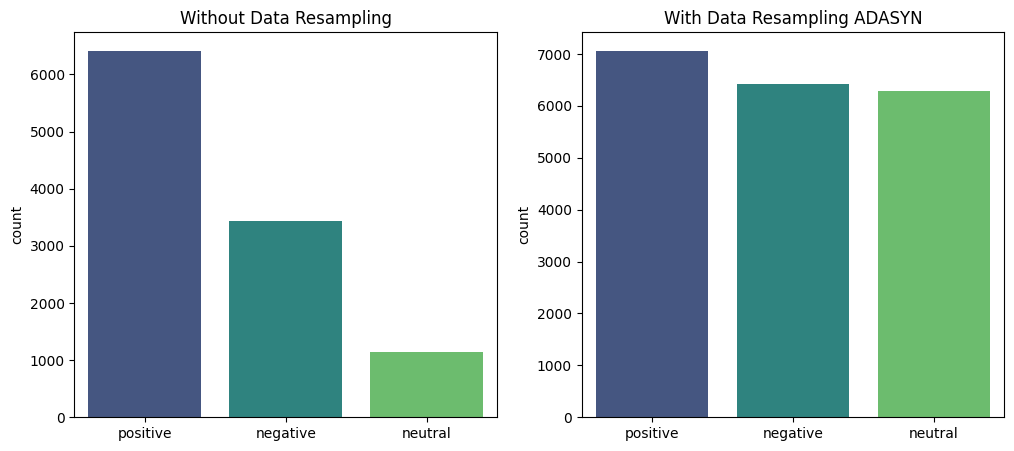

In [14]:
labels = list(['positive', 'negative', 'neutral' ])

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.barplot(x=labels, y=Y_tra.value_counts(), palette='viridis', hue = labels)
plt.title('Without Data Resampling')

plt.subplot(1,2,2)
sns.barplot(x=labels, y=ada_train_y.value_counts(), palette='viridis', hue = labels)
plt.title('With Data Resampling ADASYN')

plt.show()

## Classification

In [55]:
clf = MultinomialNB()
k_folds = RepeatedKFold(n_splits = 5, n_repeats = 5, random_state=42)

scores = cross_val_score(clf, X_tra,Y_tra, cv = k_folds, scoring = 'accuracy')

print("Average accuracy Score: ", scores.mean())

Average accuracy Score:  0.7889636363636363


In [57]:
# Test final model on the test set

clf.fit(X_tra,Y_tra)
y_pred = clf.predict(X_tes)
test_accuracy = accuracy_score(Y_tes, y_pred)

print('Confusion Matrix')
print(confusion_matrix(Y_tes,y_pred),"\n")
print('Classification Report')
print(classification_report(Y_tes,y_pred),"\n")

Confusion Matrix
[[698   0  37]
 [ 39  34  58]
 [100   0 294]] 

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       735
           1       1.00      0.26      0.41       131
           2       0.76      0.75      0.75       394

    accuracy                           0.81      1260
   macro avg       0.86      0.65      0.68      1260
weighted avg       0.83      0.81      0.80      1260
 



In [50]:
clf_ada = MultinomialNB()
k_folds = RepeatedKFold(n_splits = 5, n_repeats = 5, random_state=42)

scores = cross_val_score(clf_ada, ada_train_x,ada_train_y, cv = k_folds, scoring = 'accuracy')

print("Average accuracy Score: ", scores.mean())

Average accuracy Score:  0.8787978074357506


In [54]:
# Test final model on the test set

clf_ada.fit(ada_train_x, ada_train_y)
y_pred = clf_ada.predict(X_tes)
test_accuracy = accuracy_score(Y_tes, y_pred)

print('Confusion Matrix')
print(confusion_matrix(Y_tes,y_pred),"\n")
print('Classification Report')
print(classification_report(Y_tes,y_pred),"\n")

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       735
           1       0.72      0.74      0.73       131
           2       0.80      0.80      0.80       394

    accuracy                           0.85      1260
   macro avg       0.81      0.81      0.81      1260
weighted avg       0.85      0.85      0.85      1260
 



## Conclusion

ADASYN with parameter n_neighbors = 7 increased the model's accuracy from 79% to 88%. Although the prediction results for positive sentiment decreased, the predictions for neutral and negative sentiments improved. The ADASYN method also increased the recall values for the neutral and negative classes. Recall score shows the percentage of data samples that a machine learning model correctly identifies out of the total samples for that class. In other words, the system was able to predict more neutral and negative samples with ADASYN than without ADASYN.